In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<font size=6>**Classical Statistics: Maximum Likelihood Estimation**</font>


### Let's take some data from the literature for RR Lyrae stars in M4

RR Lyrae stars are variable pulsators that obey a precise period-luminosity relation. Here we have a sample of RR Lyrae stars in the globular cluster M4, observed with Spitzer by Neeley et al. (2015): http://cdsads.u-strasbg.fr/abs/2015ApJ...808...11N

Since the stars are at the same distance, then the apparent magnitude will also depend on the period::

$$ m = a\ {\rm log}\ P + b $$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

RR_lyrae_table2 = Table.read('./data/table2.dat', readme='./data/ReadMe', format='cds')
RR_lyrae = RR_lyrae_table2[RR_lyrae_table2['Mode'] == 'RRab']

# Now remove sources V20 and V21 due to blending
RR_lyrae = RR_lyrae[RR_lyrae['ID'] != 'V20']
RR_lyrae = RR_lyrae[RR_lyrae['ID'] != 'V21']

print("Columns:", RR_lyrae.colnames)
logP, m36, e_m36 = RR_lyrae["logP"], RR_lyrae['[3.6]'], RR_lyrae['e_[3.6]']
logP, m36, e_m36 = logP[~m36.mask], m36[~m36.mask], e_m36[~m36.mask]

Columns: ['ID', 'RAh', 'RAm', 'RAs', 'DE-', 'DEd', 'DEm', 'DEs', 'Per', 'logP', '[3.6]', 'e_[3.6]', 'f_[3.6]', '[4.5]', 'e_[4.5]', 'f_[4.5]', '3.6amp', 'e_3.6amp', '4.5amp', 'e_4.5amp', 'Mode', 'f_Mode']


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 186.90598361947244
             x: [-2.338e+00  1.030e+01]
           nit: 34
          nfev: 66
 final_simplex: (array([[-2.338e+00,  1.030e+01],
                       [-2.338e+00,  1.030e+01],
                       [-2.338e+00,  1.030e+01]]), array([ 1.869e+02,  1.869e+02,  1.869e+02]))


findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


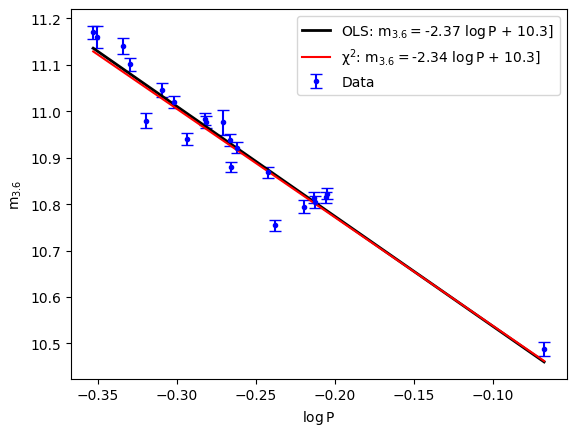

In [3]:
# ordinary least squares fit
ols_params = np.polyfit(logP, m36, deg=1)

# chi-square fitting
def to_minimize(params):
    a, b = params
    m36_model = a * logP + b
    return np.sum((m36 - m36_model) ** 2.0 / e_m36**2.0)


from scipy.optimize import minimize
print(minimize(to_minimize, x0=ols_params, method="Nelder-Mead"))

# weighted ordinary least squares fit: w = 1/sigma here!
ch2_params = np.polyfit(logP, m36, deg=1, w=1.0/e_m36)


xx = np.linspace(np.min(logP), np.max(logP), 40)

plt.figure()
plt.errorbar(logP, m36, yerr=e_m36, fmt="b.", capsize=4, label="Data")
plt.plot(xx, np.polyval(ols_params, xx), "k-", lw=2, label=f"OLS: $m_{{3.6}} = ${ols_params[0]:.3g} $\log P$ + {ols_params[1]:.3g}]")
plt.plot(xx, np.polyval(ch2_params, xx), "r-", label=f"$\chi^2$: $m_{{3.6}} = ${ch2_params[0]:.3g} $\log P$ + {ch2_params[1]:.3g}]")
plt.legend(loc="upper right")
plt.xlabel(r"$\log P$")
plt.ylabel(r"$m_{3.6}$")
plt.show()

Just by looking at it we cannot constrain the M/L ratio. How can we estimate it?


## 1.2. Constructing a likelihood function

Our problem falls into the general case where we have a model connecting two quantities through a function of one parameter, $\theta$ (in our case the M/L ratio):

$$ \Large y = f(x; \theta) $$

Therefore, if we get $N$ data, $(x_i, y_i)$ for $i \in [1, 2, \cdots, N]$ based on the model we would expect:

$$\Large y_i = f(x_i; \theta) $$

However, all observations are **subject to uncertainty**, and we need to model this as well. More often than not, uncertainties are fluctuations of a certain magnitude $\sigma$ around 0, following the Gaussian distribution:

$$\Large y_i = f(x_i; \theta) + \epsilon_i $$

where $\epsilon_i$ is normally distributed:

$$\Large \epsilon_i \sim \mathrm{Norm}(0, \sigma_i)$$

The $\sigma_i$ is the standard deviation of the datum error distribution, or an **estimate** of the typical difference between the observed $y_i$ and the intrinsic, true value $y_i$ which we **assume that is described by the model**.

Consequently, according to our model, the probability to observe the $i$-th point's $y$-value, or the **datum likelihood** is

$$\Large
P(x_i, y_i) = \text{Norm}(y_i; f(\theta; x_i), \sigma_i) 
   = \dfrac{1}{\sqrt{2\pi \sigma_i^2}} \exp \left[{-\dfrac{(y_i-f(x_i; \theta))^2}{2\sigma_i^2}} \right]
$$

Assuming that our measurements are independent (the probability of $y_2$ does not depend on $y_1$), the overall probability to get our data, or **likelihood** (always **according to our model**) is the product of all likelihoods:

$$\Large L = \prod_{i=1}^{N} P(x_i, y_i)$$

Let's do the math...

$$\Large
L = \prod_{i=1}^{N} \dfrac{1}{\sqrt{2\pi \sigma_i^2}} \exp \left[{-\dfrac{(y_i-f(x_i))^2}{2\sigma_i^2}} \right]
$$

$$\Large
L = \left(\dfrac{1}{\sqrt{2\pi \sigma_i^2}}\right)^N \exp \left[ -\sum_{i=1}^{N} {\dfrac{(y_i-f(x_i))^2}{2\sigma_i^2}} \right]
$$

Since the likelihood is a very small, but positive quantity, we can work in log-space:

$$\Large
l = \ln{L} = -\frac{N}{2} \ln\left(2\pi \sigma^2\right) - \sum_{i=1}^{N} {\dfrac{(y_i-f(x_i))^2}{2\sigma_i^2}}
$$


The parameters that maximize the likelihood are found by taking

$$\Large \frac{\partial L}{\partial a} = 0 \qquad\text{and}\qquad \Large \frac{\partial L}{\partial b} = 0$$

or equivalently,

$$\Large \frac{\partial l}{\partial a} = 0 \qquad\text{and}\qquad \Large \frac{\partial l}{\partial b} = 0.$$

Since the first term of the log-likelihood is constant, this is the same as minimizing the quantity

$$\Large \sum_{i=1}^{N} {\dfrac{(y_i-f(x_i))^2}{2\sigma_i^2}} $$

...which is the **$\chi^2$ statistic**!


## If the uncertainties are equal...

If $\sigma_i \equiv \sigma$, then... we just need to minimize the quantity

$$\Large \sum_{i=1}^{N} (y_i-f(x_i))^2 $$

...or the **sum of the squares**!

In fact, using $f(x) = a x + b$ you will arrive at the known OLS formulae!

/tmp/ipykernel_94064/319766110.py:16: UserWarning: The following kwargs were not used by contour: 'lw'
  plt.contour(A, B, 10.0**logL, [10.0**-0.5], colors='black', lw=0.5)


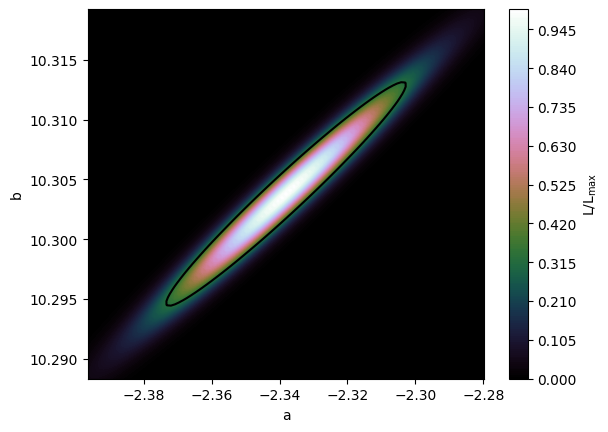

In [53]:
ch2_params[0]
a_grid = np.linspace(0.975 * ch2_params[0], 1.025 * ch2_params[0], 101)
b_grid = np.linspace(0.9985 * ch2_params[1], 1.0015 * ch2_params[1], 101)

[A, B] = np.meshgrid(a_grid, b_grid)

@np.vectorize
def log_likelihood(a, b):
    return -to_minimize([a, b])

logL = log_likelihood(A, B)
logL = logL - np.max(logL)

plt.figure()
plt.contour(A, B, 10.0**logL, [10.0**-0.5], colors='black', lw=0.5)
plt.contourf(A, B, 10.0**logL, 200, cmap='cubehelix')
plt.xlabel("a")
plt.ylabel("b")
plt.colorbar(label=r"$L / L_{\max}$")
plt.show()

*WARNING: The height and the width of the curves depends on the constant terms which, for now, we have ignored. The peak is in the correct position*:

$$\Large \text{For } f(x) = A g(x) + B, \text{ then } f'(x) = 0 \Rightarrow A g'(x) = 0 \Rightarrow g'(x) = 0 $$

*Also, taking the $\ln$ or $\log$ of a positive function doesn't shift the minima/maxima:

$$\Large \left[\ln f(x) \right]' = 0 \Rightarrow \dfrac{f'(x)}{f(x)} = 0 \Rightarrow f'(x) = 0 $$



## 1.3. Maximizing the likelihood analytically

We can get the best-fitting values of model parameters by maximizing the likelihood function:

$$\Large \frac{\partial L}{\partial \theta_i} = 0 \qquad \mathrm{or} \qquad \frac{\partial l}{\partial \theta_i} = 0$$

or it's log-version:

$$\Large \frac{\partial l}{\partial \theta_i} = 0 $$


for all parameters $\theta_i$ of the model. Typically, we need to also ensure that it's not a minimum:

$$\Large \frac{\partial^2 L}{\partial \theta_i^2}(\theta_i') < 0 $$


## 1.4. Maximizing the likelihood: numerically

An analytical solution might not exist. No worries, we can always use the numerical approach which works pretty well and fast for most cases. Note that `scipy` provides powerful methods to **minimize** functions.

<font size=3><u>**In-class discussion: would we get the same result by fitting with ordinary least-squares?**</u><font>

<details>
<summary><b>[Spoiler]</b></summary>
<br>
A least-squares fit is what we did! We minimized -$f(\theta)$ where $f(\theta)$ is the negative sum of square differences between the prediction (from $\theta$) and the observations!
<br>

<font size=3><u>**In-class discussion: if yes, is it because the data appear to have a linear correlation?**</u><font>

<details>
<summary><b>[Spoiler]</b></summary>
<br>
The fact that we perform a least-squares fit (numerically rather than analytically) is a consequence of the likelihood function, not the form of the data! The assumptions of least-squares method (e.g., linear parameters in the model, Gaussian residuals around 0, independent samples, etc.) are the same with the ones we made!

It's not difficult to imagine cases where the there is linear correlation, but the likelihood would have to be different: number of stars vs. mass of a galaxy.
<br>

# 2. Hypothesis testing: dependence/independence

# 2.9. Dependence/independence of random variables
Sometimes we want to test whether two quantities are (un)correlated, or *(in)dependent*. This is useful for 
* confirming a model predicting that such a correlation exists
* predicting a quantity (e.g., 'y' from 'x')
* verify a monotonic relation between two quantities

## Linear correlation tests

In the begining of the chapter, we assumed that the K-band luminosity and the mass are correlated, and therefore the logarithm of the mass is linearly correlated with the absolute magnitude:

$$\Large 
    \begin{cases} 
        M &= \Upsilon L_K \\
        \dfrac{L}{L_\odot} &= 10^{0.4\left(M_{K,\odot}-M_K\right)}
    \end{cases}
    \Rightarrow
    \log (M/M_\odot) = a M_K + b
$$
where the $a$ and $b$ parameters are expressions of the mass-to-light ratio, the solar K-band absolute magnitude, etc.

We can perform an ordinary least-squares fit to get the best-fitting values of $a$ and $b$. The function `linregress` provided by the `scipy` package can be used. It also returns a $p$-value based on the result!  

The documentation reports:
> The p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.


FIT RESULTS:
    slope          : -0.40 +/- 0.01
    intercept      : 1.26 +/- 0.08
    corr. coeff. R : -0.987370
    R squared      : 0.974900
    p-value        : 5.54919e-65


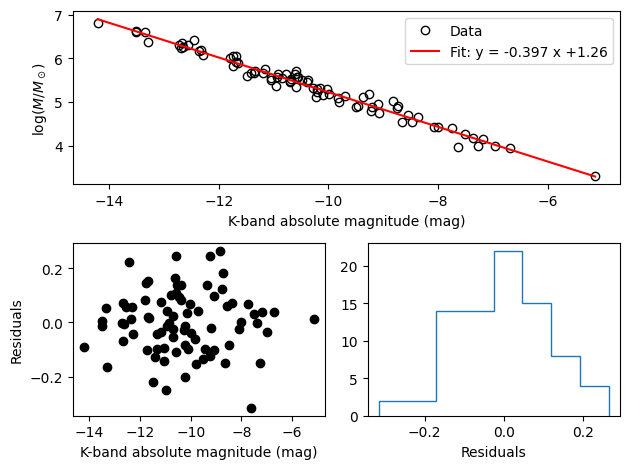

In [20]:
res = st.linregress(x=K_absolute_magnitudes, y=log_masses)

slope, intercept, rvalue, pvalue, slope_stderr = res
intercept_stderr = res.intercept_stderr                # for compatibility this value is extracted like this

print("FIT RESULTS:")
print("    slope          : {:.2f} +/- {:.2f}".format(slope, slope_stderr))
print("    intercept      : {:.2f} +/- {:.2f}".format(intercept, intercept_stderr))
print("    corr. coeff. R : {:.6f}".format(rvalue))
print("    R squared      : {:.6f}".format(rvalue**2.0))
print("    p-value        : {:.6g}".format(pvalue))

x_plot = np.array([min(K_absolute_magnitudes), max(K_absolute_magnitudes)])
y_plot = slope * x_plot + intercept

plt.figure()
plt.subplot(211)
plt.plot(K_absolute_magnitudes, log_masses, "ko", mfc="none", label="Data")
plt.plot(x_plot, y_plot, "r-", label="Fit: y = {:.3g} x {:+.3g}".format(slope, intercept))
plt.xlabel("K-band absolute magnitude (mag)")
plt.ylabel("$\log(M/M_\odot)$")
plt.legend(loc="upper right")

residuals = log_masses - (slope * K_absolute_magnitudes + intercept)
# plt.figure(constrained_layout=True)
plt.subplot(223)
plt.plot(K_absolute_magnitudes, residuals, "ko")
plt.xlabel("K-band absolute magnitude (mag)")
plt.ylabel("Residuals")
plt.subplot(224)
plt.hist(residuals, bins="fd", histtype="step")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()

Pearson correlation coefficient:

$$ \large \rho = \dfrac{\mathrm{cov}\left(X, Y\right)}{\sigma_X \sigma_Y} $$

For a sample:

$$ \large
    r = \dfrac{
              \sum\limits_{i=1}^{n}\left(x_i - \bar{x}\right)\left(y_i - \bar{y}\right)
              }
              {
              \sqrt{
              \sum\limits_{i=1}^{n}\left(x_i - \bar{x}\right)^2
              \sum\limits_{i=1}^{n}\left(y_i - \bar{y}\right)^2
              }
              }
$$

- 0: no correlation. 
- 1: perfect correlation
- -1: perfect anti-correlation.

The square of $r$, usually refered as **R-squared** in the literature, is the *percentage of explained variance through the linear correlation*.

Therfore, a $p$-value smaller than our significance level, means that **we reject the hypothesis that the slope is 0**, which can be rephrased as **we cannot reject the hypothesis that there is a linear correlation**.

**Warning**: this doesn't mean that we accept that the correlation is linear. We get the above result *assuming linear correlation*!


### If we do not need to fit, we can use the `pearsonr` function to perform the hypothesis test

**Warning**: this does not alleviate the caveat that the correlation might not be linear!

In [21]:
st.pearsonr(K_absolute_magnitudes, log_masses)

PearsonRResult(statistic=-0.9873702567487689, pvalue=5.5491936681630286e-65)

## Monotonicity test

Sometimes a linear correlation does not exist! For example, if we had no intuition about the connection between the K-band absolute magnitudes and masses of globular clusters, plotting them we would see a trend! The higher the magnitude, the lower the mass.

The Pearson correlation test would... not be very appropriate without logging the mass! Let's see that:

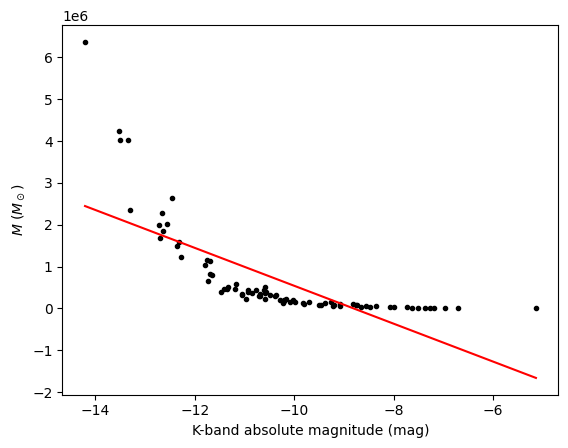

In [22]:
x, y = K_absolute_magnitudes, masses
slope, intercept, _, _, _ = st.linregress(x, y)

xx = np.linspace(min(x), max(x), 100)
plt.figure()
plt.plot(x, y, "k.")
plt.plot(xx, slope * xx + intercept, "r-")
plt.xlabel("K-band absolute magnitude (mag)")
plt.ylabel("$M$ $(M_\odot)$")
plt.show()

To test for such dependences, we can perform a **monotonicity test**. There are two widely used monotonicity checks through the *Spearman rank correlation coefficient* $r_s$ and the *Kendall rank correlation coefficient* $\tau$ often referred as *Kendall's $\tau$*. Their power relies on the fact that they are *non-parametric* and therefore they do not rely on an assumed model describing the data.

For $r_s$ and $\tau$:
- 0: $x$ and $y$ are independent
- 1: strictly increasing
- -1: strictly decreasing

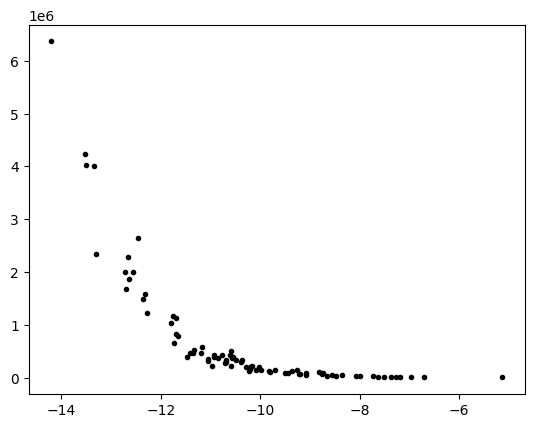

PEARSON  : r = -0.730  |  p-value = 1.08e-14
SPEARMAN : r = -0.980  |  p-value = 4.08e-57
KENDALL  : t = -0.892  |  p-value = 4.36e-32


In [23]:
x, y = K_absolute_magnitudes, masses

plt.figure()
plt.plot(x, y, "k.")
plt.show()
# report correlation tests' p-values
r, pvalue = st.pearsonr(x, y)
print("PEARSON  : r = {:.3f}  |  p-value = {:.3g}".format(r, pvalue))
r, pvalue = st.spearmanr(x, y)
print("SPEARMAN : r = {:.3f}  |  p-value = {:.3g}".format(r, pvalue))
r, pvalue = st.kendalltau(x, y)
print("KENDALL  : t = {:.3f}  |  p-value = {:.3g}".format(r, pvalue))

<font size=3><u>**In-class discussion: How do you interprete the small Pearson's $r$-value?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
Despite the fact that the correlation is obvisouly non-linear, even the wrong model has to have a non-zero slope! Always remember your $H_0$ hypothesis! 
<br>

# Exercise 3: What happens when we have few data?

Let's try with random subsets of the data, of size 5. Run the following block several times and observe the resulting $p$-values of the correlation/monotonicity tests.

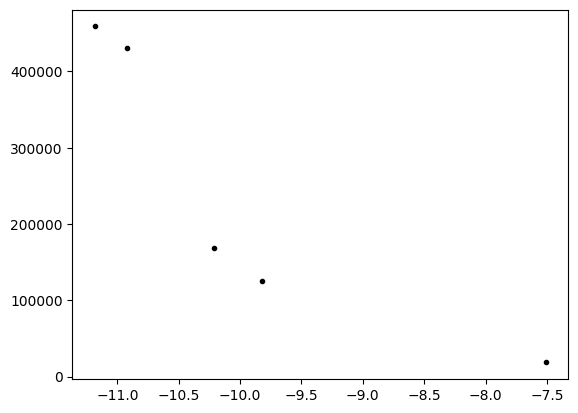

PEARSON  : r = -0.874  |  p-value = 0.0529
SPEARMAN : r = -1.000  |  p-value = 1.4e-24
KENDALL  : t = -1.000  |  p-value = 0.0167


In [24]:
subset_size = 5
random_subset = np.random.choice(len(masses), size=subset_size)

x, y = K_absolute_magnitudes[random_subset], masses[random_subset]

plt.figure()
plt.plot(x, y, "k.")
plt.show()
# report correlation tests' p-values
r, pvalue = st.pearsonr(x, y)
print("PEARSON  : r = {:.3f}  |  p-value = {:.3g}".format(r, pvalue))
r, pvalue = st.spearmanr(x, y)
print("SPEARMAN : r = {:.3f}  |  p-value = {:.3g}".format(r, pvalue))
r, pvalue = st.kendalltau(x, y)
print("KENDALL  : t = {:.3f}  |  p-value = {:.3g}".format(r, pvalue))

<font size=3><u>**In-class discussion: Run it many times. Do you notice differences in the Spearman and Kendall $p$-values?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
All $p$-values vary, and sometimes close to our significance level of $5\%$!

Spearman's $p$-values vary by orders of magnitude!

Kendall's $p$-values are never too extreme! In general, it is a more robust method!
<br>